# Basic surface water mass transformation for MPAS runs

Basic surface water mass visualization of the calculations based on `basic_surface_wmt.py`. For generating the results, see README.

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Load postprocessed results for CORE-II LR and HR G-cases

Generated with `basic_surface_wmt.py` and `ncrcat` in GNU Parallel. See README.

In [2]:
# Load postprocessed WMT files
savepath = '/pscratch/sd/b/bmoorema/wmt/basic_example'
wmt = {}
for meshName in ['LR', 'HR']:
    wmt[meshName] = {}
    for ctgy in ['1D', '2D']:
        wmt[meshName][ctgy] = xr.open_dataset(f'{savepath}/{meshName}_WMT{ctgy}_years1-10.nc')

***

### Output data structures

Here are previews of the `xarray.Dataset` structures for the LR results for 1D and 2D.

In [3]:
# xr.Dataset structure for the 1D results
wmt['LR']['1D']

<xarray.Dataset> Size: 5MB
Dimensions:                     (time: 120, regionNames: 11, densityBins: 171)
Coordinates:
  * time                        (time) datetime64[ns] 960B 1948-01-01 ... 195...
  * regionNames                 (regionNames) <U23 1kB 'Greenland Sea' ... 'R...
  * densityBins                 (densityBins) float64 1kB 26.5 26.51 ... 28.2
Data variables:
    densityHeatTransformation   (time, regionNames, densityBins) float64 2MB ...
    densitySaltTransformation   (time, regionNames, densityBins) float64 2MB ...
    densityTotalTransformation  (time, regionNames, densityBins) float64 2MB ...

In [4]:
# xr.Dataset structure for the 2D results
wmt['LR']['2D']

<xarray.Dataset> Size: 16GB
Dimensions:                    (time: 120, lat: 170, lon: 280, densityBins: 171)
Coordinates:
  * time                       (time) datetime64[ns] 960B 1948-01-01 ... 1957...
  * lat                        (lat) float64 1kB 0.25 0.75 1.25 ... 84.25 84.75
  * lon                        (lon) float64 2kB -99.75 -99.25 ... 39.25 39.75
  * densityBins                (densityBins) float64 1kB 26.5 26.51 ... 28.2
Data variables:
    densityHeatTransformation  (time, densityBins, lat, lon) float64 8GB ...
    densitySaltTransformation  (time, densityBins, lat, lon) float64 8GB ...

***

### Plots

1D transformation summary

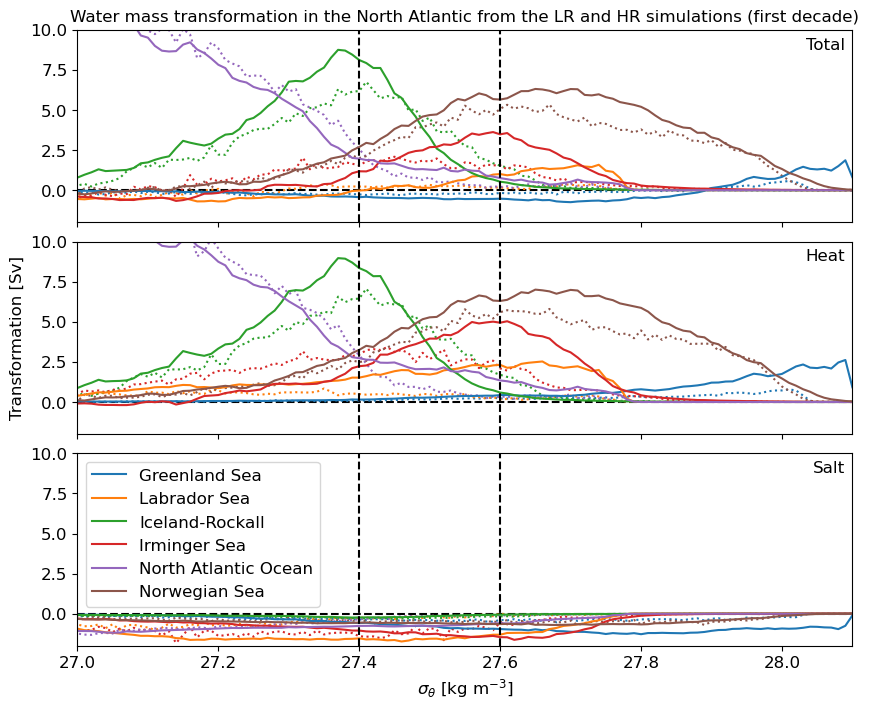

In [5]:
# Requested regions
regionNames = [
    'Greenland Sea', 'Labrador Sea', 'Iceland-Rockall',
    'Irminger Sea', 'North Atlantic Ocean', 'Norwegian Sea',
]

# Make figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.1})
palette = plt.get_cmap('tab10').colors
xlim, ylim = [27, 28.1], [-2, 10]

# Loop through panels and transformation categories
for ax, ctgy in zip(axs, ['Total', 'Heat', 'Salt']):
    
    # Loop through meshes and regions
    for meshName, ls in zip(['LR', 'HR'], [':', '-']):
        for regionName, color in zip(regionNames, palette):
            
            # Plot transformation averaged over first 12 months of simulation
            label = regionName if ls == '-' else None
            y = wmt[meshName]['1D']['density' + ctgy + 'Transformation'].sel(regionNames=regionName).mean(dim='time')
            x = y.densityBins
            ax.plot(x, y, ls, color=color, label=label)
    
    # Formatting
    for sigma in [27.4, 27.6]:
        ax.plot([sigma, sigma], ylim, 'k--')
    ax.plot(xlim, [0, 0], 'k--', zorder=-10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.text(0.99, 0.9, ctgy, transform=ax.transAxes, ha='right')
    if ctgy != 'Salt':
        ax.xaxis.set_ticklabels('')

# Final formatting
axs[2].set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
axs[1].set_ylabel('Transformation [Sv]')
axs[0].set_title('Water mass transformation in the North Atlantic from the LR and HR simulations (first decade)')
axs[2].legend()
plt.show()

2D transformation summary

In [6]:
def plot_2D_transformation(sigmaBin):
    """Plot 2D transformation on the sigmaBin
    """
    
    # Get sigmaBin slice
    slc = slice(sigmaBin-0.05, sigmaBin+0.05)

    # Make figure
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    xlim, ylim = [-70, 20], [40, 80]

    # Loop through rows and transformation categories
    for row, ctgy in zip(axs, ['Total', 'Heat', 'Salt']):
        row[0].set_ylabel(ctgy + ' transformation')

        # Loop through panels and meshes
        residual = []
        for ax, meshName in zip(row, ['LR', 'HR']):

            # Plot transformation averaged over first 12 months of simulation on sigmaBin
            wmt_sigma = wmt[meshName]['2D'].sel(densityBins=slc).mean(dim=['time', 'densityBins'])
            if ctgy == 'Total':
                z = []
                for component in ['Heat', 'Salt']:
                    varName = 'density' + component + 'Transformation'
                    z.append(wmt_sigma[varName])
                z = np.add(*z)
            else:
                varName = 'density' + ctgy + 'Transformation'
                z = wmt_sigma[varName]
            x, y = z.lon, z.lat
            c1 = ax.pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='BrBG_r')
            residual.append(z)

        # Plot residual
        residual = np.subtract(*residual[::-1])
        c2 = row[2].pcolormesh(x, y, residual, vmin=-20, vmax=20, cmap='RdBu_r')

    # Formatting
    pos = []
    for col, title in zip(axs.T, ['LR', 'HR', 'HR-LR']):
        col[0].set_title(title)
        pos.append(col[2].get_position())
        for ax in col:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

    # Add colorbars
    cax1 = fig.add_axes([pos[0].x0, 0.08, pos[1].x1 - pos[0].x0, 0.01])
    cax2 = fig.add_axes([pos[2].x0, 0.08, pos[2].width, 0.01])
    fig.colorbar(c1, cax1, orientation='horizontal', label='Sv')
    fig.colorbar(c2, cax2, orientation='horizontal', label='Sv')

Sigma 27.4

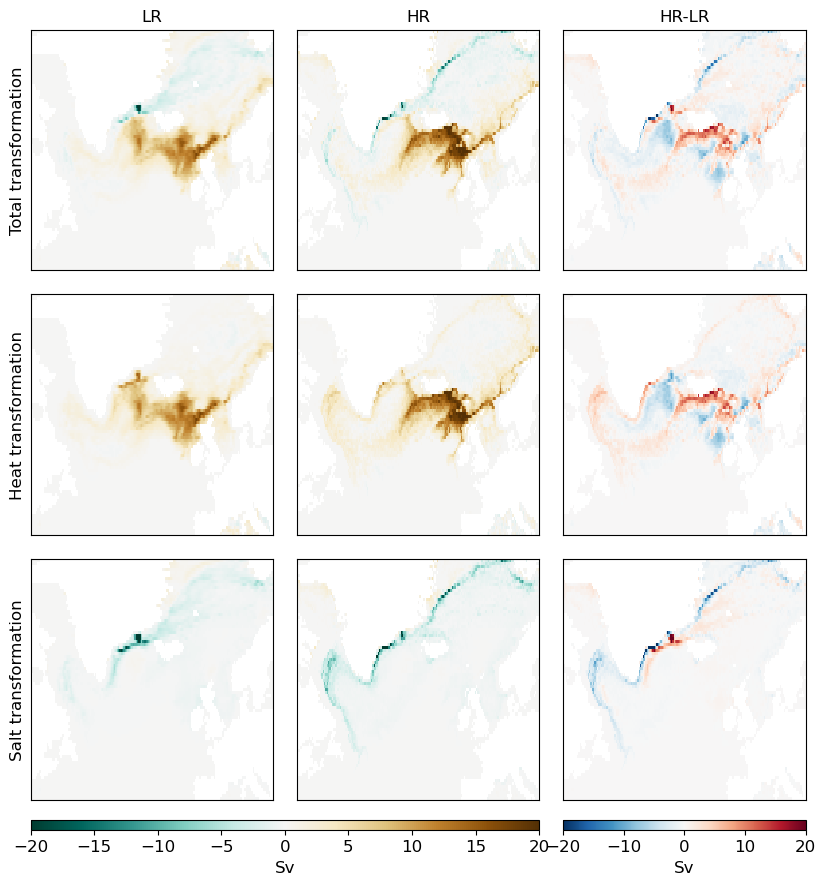

In [7]:
# Plot 2D transformation on sigma 27.4
plot_2D_transformation(27.4)

Sigma 27.6

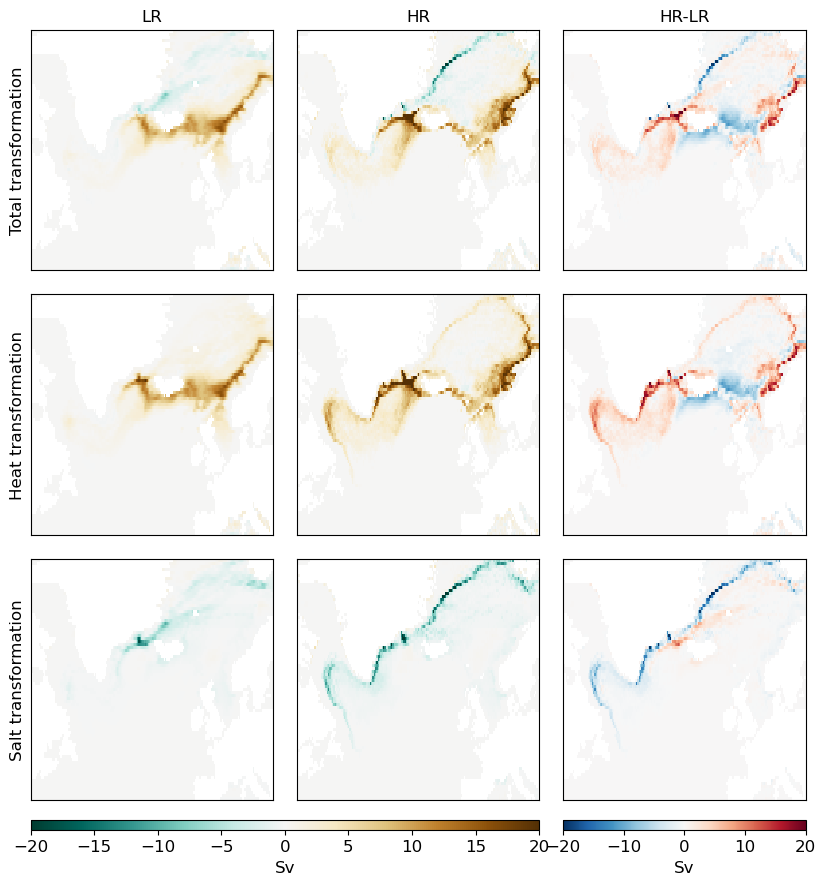

In [8]:
# Plot 2D transformation on sigma 27.6
plot_2D_transformation(27.6)